### **We use the landsat578-based prtrained model (pytorch-based) for surface water mapping**


In [29]:
# ## Mount on google drive
# from google.colab import drive
# drive.mount('/content/drive/')

In [30]:
import config
import os
os.chdir(config.root)
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from utils.geotif_io import readTiff,writeTiff
from utils.imgShow import imgShow
from utils.imgPatch import imgPatch


In [36]:
path_img = config.root + '/data/dset-l578/scene/l5_scene_01.tif'
path_wat_map = config.root + '/data/result/l5_scene_01_pred.tif'
path_trained_model =  config.root + '/model/trained/watnet_l578.pth'



In [37]:
# ## ----- model ------
""" the U-Net model: the same to the trained model """
def conv3x3_bn_relu(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, 1, 1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
        )

class unet(nn.Module):
    def __init__(self, num_bands):
        super(unet, self).__init__()
        self.num_bands = num_bands
        self.up = nn.Upsample(scale_factor=2, mode='nearest')
        self.down_conv1 = conv3x3_bn_relu(num_bands, 16)
        self.down_conv2 = conv3x3_bn_relu(16, 32)
        self.down_conv3 = conv3x3_bn_relu(32, 64)
        self.down_conv4 = conv3x3_bn_relu(64, 128)
        self.up_conv1 = conv3x3_bn_relu(192, 64)
        self.up_conv2 = conv3x3_bn_relu(96, 48)
        self.up_conv3 = conv3x3_bn_relu(64, 32)
        self.outp = nn.Sequential(
                nn.Conv2d(32, 1, kernel_size=3, padding=1),
                nn.Sigmoid()) 

    def forward(self, x):  ## input size: 6x256x256
        ## encoder part
        x1 = self.down_conv1(x)              
        x1 = F.avg_pool2d(input=x1, kernel_size=2)  # 16x128x128
        x2 = self.down_conv2(x1)              
        x2 = F.avg_pool2d(input=x2, kernel_size=2) # 32x64x64
        x3 = self.down_conv3(x2)              
        x3 = F.avg_pool2d(input=x3, kernel_size=2) # 64x32x32
        x4 = self.down_conv4(x3)              
        x4 = F.avg_pool2d(input=x4, kernel_size=2) # 128x16x16
        ## decoder part
        x4_up = torch.cat([self.up(x4), x3], dim=1)  # (128+64)x32x32
        x3_up = self.up_conv1(x4_up)  # 64x32x32
        x3_up = torch.cat([self.up(x3_up), x2], dim=1)  # (64+32)x64x64
        x2_up = self.up_conv2(x3_up)  # 48x64x64
        x2_up = torch.cat([self.up(x2_up), x1], dim=1)  # (48+16)x128x128
        x1_up = self.up_conv3(x2_up)    # 32x128x128
        x1_up = self.up(x1_up)        # 32x256x256
        logits = self.outp(x1_up)
        return logits          

model = unet(num_bands=6)
model.load_state_dict(torch.load(path_trained_model))


<All keys matched successfully>

In [38]:
### surface water mapping by using trained model
print('image:', path_img)
### --- 1. read in .tif image
# satellite images 
img, img_info = readTiff(path_in=path_img)
img = np.float32(np.clip(img/10000, a_min=0, a_max=1))     ### normalization

### ---- 2. surface water mapping 
imgPat_ins = imgPatch(img=img, patch_size=512, edge_overlay = 160)
patch_list, start_list, img_patch_row, img_patch_col = imgPat_ins.toPatch()
patch_list = [torch.from_numpy(patch.transpose(2,0,1)) for patch in patch_list]  # 1.channel first and 2.numpy array to torch tensor
result_patch_list = [model(patch[np.newaxis, :]) for patch in patch_list]
result_patch_list = [np.squeeze(patch.detach().numpy().transpose(0,2,3,1), axis = 0) for patch in result_patch_list] ## 1.channel last and 2.torch tensor to numpy array
pro_map = imgPat_ins.toImage(result_patch_list, img_patch_row, img_patch_col)
cla_map = np.where(pro_map>0.5, 1, 0)
cla_map = np.int8(cla_map)

## --- 3. save the result
writeTiff(im_data=cla_map,  
            im_geotrans=img_info['geotrans'], 
            im_geosrs=img_info['geosrs'], 
            path_out=path_wat_map)

print('saved image -->:', path_wat_map)
    
    

image: /Users/luo/Library/CloudStorage/OneDrive-Personal/GitHub/landsat578-water/data/dset-l578/scene/l5_scene_01.tif
saved image -->: /Users/luo/Library/CloudStorage/OneDrive-Personal/GitHub/landsat578-water/data/result/l5_scene_01_pred.tif


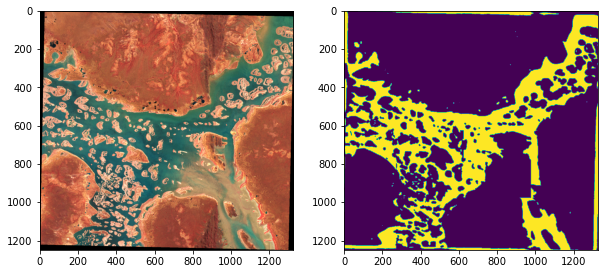

In [39]:
## show the image and the prediction map
scene_name = 'l5_scene_01'
path_img = 'data/dset-l578/scene/'+ scene_name+'.tif'
path_pred = 'data/result/'+ scene_name + '_pred.tif'
img, _ = readTiff(path_in=path_img)
pred, _ = readTiff(path_in=path_pred)
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
imgShow(img, color_bands=(3,2,1), clip_percent=2)
plt.subplot(1,2,2)
imgShow(pred, color_bands=(0,0,0), clip_percent=1)